# PES of Hydrogen Molecule With Various IBMQ Noise and Mitiq

We attempt to improve the noisy results using [Noise Zero Extrapolation](https://mitiq.readthedocs.io/en/stable/guide/zne.html) from [Mitiq](https://mitiq.readthedocs.io/en/stable/index.html). [[1]] (https://arxiv.org/abs/2009.04417)

[[1]](https://arxiv.org/abs/2009.04417)  Ryan LaRose, Andrea Mari, Sarah Kaiser, Peter J. Karalekas, Andre A. Alves, Piotr Czarnik, Mohamed El Mandouh, Max H. Gordon, Yousef Hindy, Aaron Robertson, Purva Thakre, Nathan Shammah, & William J. Zeng. (2021). Mitiq: A software package for error mitigation on noisy quantum computers.

In [1]:
# Native Lib
import itertools as it
import json
import time

# External Lib
import qiskit
import numpy as np
import pennylane as qml
from pennylane import numpy as plnp
import matplotlib.pyplot as plt
from qiskit.providers.aer.noise import NoiseModel
from mitiq.zne.scaling import fold_global
from mitiq.zne import execute_with_zne

# qanything Lib
import qanything.common_functions as cf
import qanything.get_index as getind
import qanything.get_molecule as getmol
import qanything.get_json as getjson

### Load IBM Noise Model Devices

In [8]:
# Start IBMQ
qiskit.IBMQ.load_account()

# # Get a list of backends
# backend_list = []
# for b in provider.backends():
#     backend_list.append(b.name())

# Filtered Backend List
backend_list = ['ibmq_montreal',
                'ibmq_toronto',
                'ibmq_santiago',
                'ibmq_bogota',
                'ibmq_casablanca',
                'ibmq_mumbai',
                'ibmq_lima',
                'ibmq_belem',
                'ibmq_quito',
                'ibmq_guadalupe',
                'ibmq_brooklyn',
                'ibmq_jakarta',
                'ibmq_manila',
                'ibm_hanoi',
                'ibm_lagos',
                'ibm_cairo',
                'ibm_auckland',
                'ibm_perth',
                'ibm_washington']

ibmqfactory.load_account:WARNING:2022-02-25 13:30:15,485: Credentials are already in use. The existing account in the session will be replaced.


In [4]:
# Load Results from Geometry Optimisation Hydrogen
h2_opt_data_filename = 'h2_morse_vqe.json'
h2_opt_data = getjson.load_from_json(h2_opt_data_filename)

Loading Data from: h2_morse_vqe.json


### Apply IBM Noise Models and Perform Noise Zero Extrapolation (NZE)

In [12]:
# Create Hydrogen Molecule
mol_name = 'h2'
mol_full_name = 'hydrogen molecule'

# Get Hamiltonian
mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, h2_opt_data['bond_length'][0])
mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge)

# Get the Hartree-Fock State
hf = qml.qchem.hf_state(electrons=num_elec, orbitals=num_qubits)

# Prepare the UCCSD Ansatz based on the Disentangled Order
def uccsd_ansatz(params, wires, excitations):
    qml.BasisState(hf, wires=wires)
    for i, excitation in enumerate(excitations):
        if len(excitation) == 4:
            qml.DoubleExcitation(params[i], wires=excitation)
        else:
            qml.SingleExcitation(params[i], wires=excitation)

# We shall remove all single excitation and only consider the double excitation. 
disentangle_order_only_doubles = [[0, 1, 2, 3]] 

# Maximum Number of Shots available on IBMQ
num_shots = 20000
noisy_backend_noisy_morse = []
mitig_noisy_backend_noisy_morse = []
for i in range(len(backend_list)):

    print(f'\nCurrent Backend: {backend_list[i]}')
    backend = provider.get_backend(backend_list[i])
    noise_model = NoiseModel.from_backend(backend)
    dev = qml.device('qiskit.aer', wires=num_qubits, backend= 'aer_simulator', noise_model=noise_model, shots = num_shots)

    # Loop through all bond lengths and get the noisy energy.
    noisy_morse = []
    mitig_noisy_morse = []
    for j in range(len(h2_opt_data['bond_length'])):

        # Get Hydrogen Molecule Hamiltonian with new bond length
        bond_length = h2_opt_data['bond_length'][j]
        mol_symbols, coords, charge, num_elec = getmol.get_molecule(mol_name, bond_length)
        mol_ham, num_qubits = qml.qchem.molecular_hamiltonian(symbols=mol_symbols, coordinates=coords, name=mol_full_name ,charge=charge)

        # Get only double excitation rotation angle and perform only double excitation 
        params = [h2_opt_data['vqe_params'][j][2]]
        cost_fn = qml.ExpvalCost(uccsd_ansatz, mol_ham, dev, optimize=False)
        noisy_energy = cost_fn(params, excitations=disentangle_order_only_doubles)
        noisy_morse.append(noisy_energy)
        print("Bond Length: %.1f, Noisy Energy: %.5f" %(bond_length, noisy_energy))

        # Construct my Quantum Circuit
        with qml.tape.QuantumTape() as circuit:
            qml.PauliX(wires=0)
            qml.PauliX(wires=1)

            # Get only double excitation rotation angle and perform only double excitation 
            params = [h2_opt_data['vqe_params'][j][2]]
            for k, excitation in enumerate(disentangle_order_only_doubles):
                if len(excitation) == 4:
                    qml.DoubleExcitation(params[k], wires=excitation)
                else:
                    qml.SingleExcitation(params[k], wires=excitation)
        
        # Define custom executor that expands Hamiltonian measurement into a linear combination of tensor products of Pauli operators.
        def executor(circuit):

            # Add Hamiltonian measurement to circuit
            with qml.tape.QuantumTape() as circuit_with_meas:
                for o in circuit.operations:
                    qml.apply(o)
                qml.expval(mol_ham)

            # Expand Hamiltonian measurement into tensor product of Pauli operators. We get a list of circuits to execute and a postprocessing function to combine the results into a single number.
            circuits, postproc = qml.transforms.hamiltonian_expand(circuit_with_meas, group=False)
            circuits_executed = qml.execute(circuits, dev, gradient_fn=None)
            return postproc(circuits_executed)

        mitig_energy = execute_with_zne(circuit, executor, scale_noise=fold_global)
        mitig_noisy_morse.append(mitig_energy)

        print("Bond Length: %.1f, Mitig Noisy Energy: %.5f" %(bond_length, mitig_energy))

    mitig_noisy_backend_noisy_morse.append(mitig_noisy_morse)
    noisy_backend_noisy_morse.append(noisy_morse)


Current Backend: ibmq_montreal
Bond Length: 1.0, Noisy Energy: -0.92337
Bond Length: 1.0, Mitig Noisy Energy: -0.93160
Bond Length: 1.2, Noisy Energy: -0.99113
Bond Length: 1.2, Mitig Noisy Energy: -1.00340
Bond Length: 1.4, Noisy Energy: -1.01952
Bond Length: 1.4, Mitig Noisy Energy: -1.02218
Bond Length: 1.6, Noisy Energy: -1.02281
Bond Length: 1.6, Mitig Noisy Energy: -1.02073
Bond Length: 1.8, Noisy Energy: -1.01572
Bond Length: 1.8, Mitig Noisy Energy: -1.03181
Bond Length: 2.0, Noisy Energy: -1.00118
Bond Length: 2.0, Mitig Noisy Energy: -1.00450
Bond Length: 2.2, Noisy Energy: -0.98548
Bond Length: 2.2, Mitig Noisy Energy: -0.99723
Bond Length: 2.4, Noisy Energy: -0.96426
Bond Length: 2.4, Mitig Noisy Energy: -0.97024
Bond Length: 2.6, Noisy Energy: -0.94974
Bond Length: 2.6, Mitig Noisy Energy: -0.94644
Bond Length: 2.8, Noisy Energy: -0.93029
Bond Length: 2.8, Mitig Noisy Energy: -0.92236
Bond Length: 3.0, Noisy Energy: -0.92139
Bond Length: 3.0, Mitig Noisy Energy: -0.91911


Bond Length: 1.0, Noisy Energy: 0.23252
Bond Length: 1.0, Mitig Noisy Energy: 0.20926
Bond Length: 1.2, Noisy Energy: 0.01312
Bond Length: 1.2, Mitig Noisy Energy: 0.00242
Bond Length: 1.4, Noisy Energy: -0.13639
Bond Length: 1.4, Mitig Noisy Energy: -0.13917
Bond Length: 1.6, Noisy Energy: -0.24011
Bond Length: 1.6, Mitig Noisy Energy: -0.26860
Bond Length: 1.8, Noisy Energy: -0.31497
Bond Length: 1.8, Mitig Noisy Energy: -0.29928
Bond Length: 2.0, Noisy Energy: -0.37290
Bond Length: 2.0, Mitig Noisy Energy: -0.38480
Bond Length: 2.2, Noisy Energy: -0.42113
Bond Length: 2.2, Mitig Noisy Energy: -0.41389
Bond Length: 2.4, Noisy Energy: -0.44670
Bond Length: 2.4, Mitig Noisy Energy: -0.43353
Bond Length: 2.6, Noisy Energy: -0.47460
Bond Length: 2.6, Mitig Noisy Energy: -0.45996
Bond Length: 2.8, Noisy Energy: -0.48602
Bond Length: 2.8, Mitig Noisy Energy: -0.50162
Bond Length: 3.0, Noisy Energy: -0.50381
Bond Length: 3.0, Mitig Noisy Energy: -0.49998
Bond Length: 3.2, Noisy Energy: -0.5

Bond Length: 1.0, Noisy Energy: -0.88727
Bond Length: 1.0, Mitig Noisy Energy: -0.88063
Bond Length: 1.2, Noisy Energy: -0.95274
Bond Length: 1.2, Mitig Noisy Energy: -0.96480
Bond Length: 1.4, Noisy Energy: -0.98234
Bond Length: 1.4, Mitig Noisy Energy: -0.98006
Bond Length: 1.6, Noisy Energy: -0.99001
Bond Length: 1.6, Mitig Noisy Energy: -1.00612
Bond Length: 1.8, Noisy Energy: -0.98705
Bond Length: 1.8, Mitig Noisy Energy: -0.97944
Bond Length: 2.0, Noisy Energy: -0.97265
Bond Length: 2.0, Mitig Noisy Energy: -0.97421
Bond Length: 2.2, Noisy Energy: -0.95633
Bond Length: 2.2, Mitig Noisy Energy: -0.95616
Bond Length: 2.4, Noisy Energy: -0.93792
Bond Length: 2.4, Mitig Noisy Energy: -0.93990
Bond Length: 2.6, Noisy Energy: -0.92393
Bond Length: 2.6, Mitig Noisy Energy: -0.92873
Bond Length: 2.8, Noisy Energy: -0.90485
Bond Length: 2.8, Mitig Noisy Energy: -0.90462
Bond Length: 3.0, Noisy Energy: -0.89237
Bond Length: 3.0, Mitig Noisy Energy: -0.89153
Bond Length: 3.2, Noisy Energy: 

Bond Length: 1.0, Noisy Energy: -0.83937
Bond Length: 1.0, Mitig Noisy Energy: -0.83985
Bond Length: 1.2, Noisy Energy: -0.91978
Bond Length: 1.2, Mitig Noisy Energy: -0.93397
Bond Length: 1.4, Noisy Energy: -0.95512
Bond Length: 1.4, Mitig Noisy Energy: -0.93811
Bond Length: 1.6, Noisy Energy: -0.96508
Bond Length: 1.6, Mitig Noisy Energy: -0.96686
Bond Length: 1.8, Noisy Energy: -0.96180
Bond Length: 1.8, Mitig Noisy Energy: -0.97645
Bond Length: 2.0, Noisy Energy: -0.95631
Bond Length: 2.0, Mitig Noisy Energy: -0.94942
Bond Length: 2.2, Noisy Energy: -0.93885
Bond Length: 2.2, Mitig Noisy Energy: -0.94822
Bond Length: 2.4, Noisy Energy: -0.92738
Bond Length: 2.4, Mitig Noisy Energy: -0.93893
Bond Length: 2.6, Noisy Energy: -0.91007
Bond Length: 2.6, Mitig Noisy Energy: -0.90901
Bond Length: 2.8, Noisy Energy: -0.89716
Bond Length: 2.8, Mitig Noisy Energy: -0.89863
Bond Length: 3.0, Noisy Energy: -0.88868
Bond Length: 3.0, Mitig Noisy Energy: -0.88336
Bond Length: 3.2, Noisy Energy: 

Bond Length: 1.0, Noisy Energy: 0.29174
Bond Length: 1.0, Mitig Noisy Energy: 0.27646
Bond Length: 1.2, Noisy Energy: 0.05874
Bond Length: 1.2, Mitig Noisy Energy: 0.02670
Bond Length: 1.4, Noisy Energy: -0.11044
Bond Length: 1.4, Mitig Noisy Energy: -0.10526
Bond Length: 1.6, Noisy Energy: -0.20888
Bond Length: 1.6, Mitig Noisy Energy: -0.19971
Bond Length: 1.8, Noisy Energy: -0.30284
Bond Length: 1.8, Mitig Noisy Energy: -0.30202
Bond Length: 2.0, Noisy Energy: -0.35974
Bond Length: 2.0, Mitig Noisy Energy: -0.35860
Bond Length: 2.2, Noisy Energy: -0.40575
Bond Length: 2.2, Mitig Noisy Energy: -0.40079
Bond Length: 2.4, Noisy Energy: -0.43805
Bond Length: 2.4, Mitig Noisy Energy: -0.45600
Bond Length: 2.6, Noisy Energy: -0.46592
Bond Length: 2.6, Mitig Noisy Energy: -0.44435
Bond Length: 2.8, Noisy Energy: -0.48479
Bond Length: 2.8, Mitig Noisy Energy: -0.48620
Bond Length: 3.0, Noisy Energy: -0.50376
Bond Length: 3.0, Mitig Noisy Energy: -0.49099
Bond Length: 3.2, Noisy Energy: -0.5

In [13]:
# filename_noise = 'mitig_noisy_h2.json'
# save_data = {**h2_opt_data}
# save_data['ibm_devices'] = backend_list
# save_data['noisy_backend_noisy_energy'] = noisy_backend_noisy_morse
# save_data['mitig_noisy_backend_noisy_energy'] = mitig_noisy_backend_noisy_morse
# getjson.save_to_json(filename_noise,save_data)

Saving Data to: mitig_noisy_h2.json


### Results

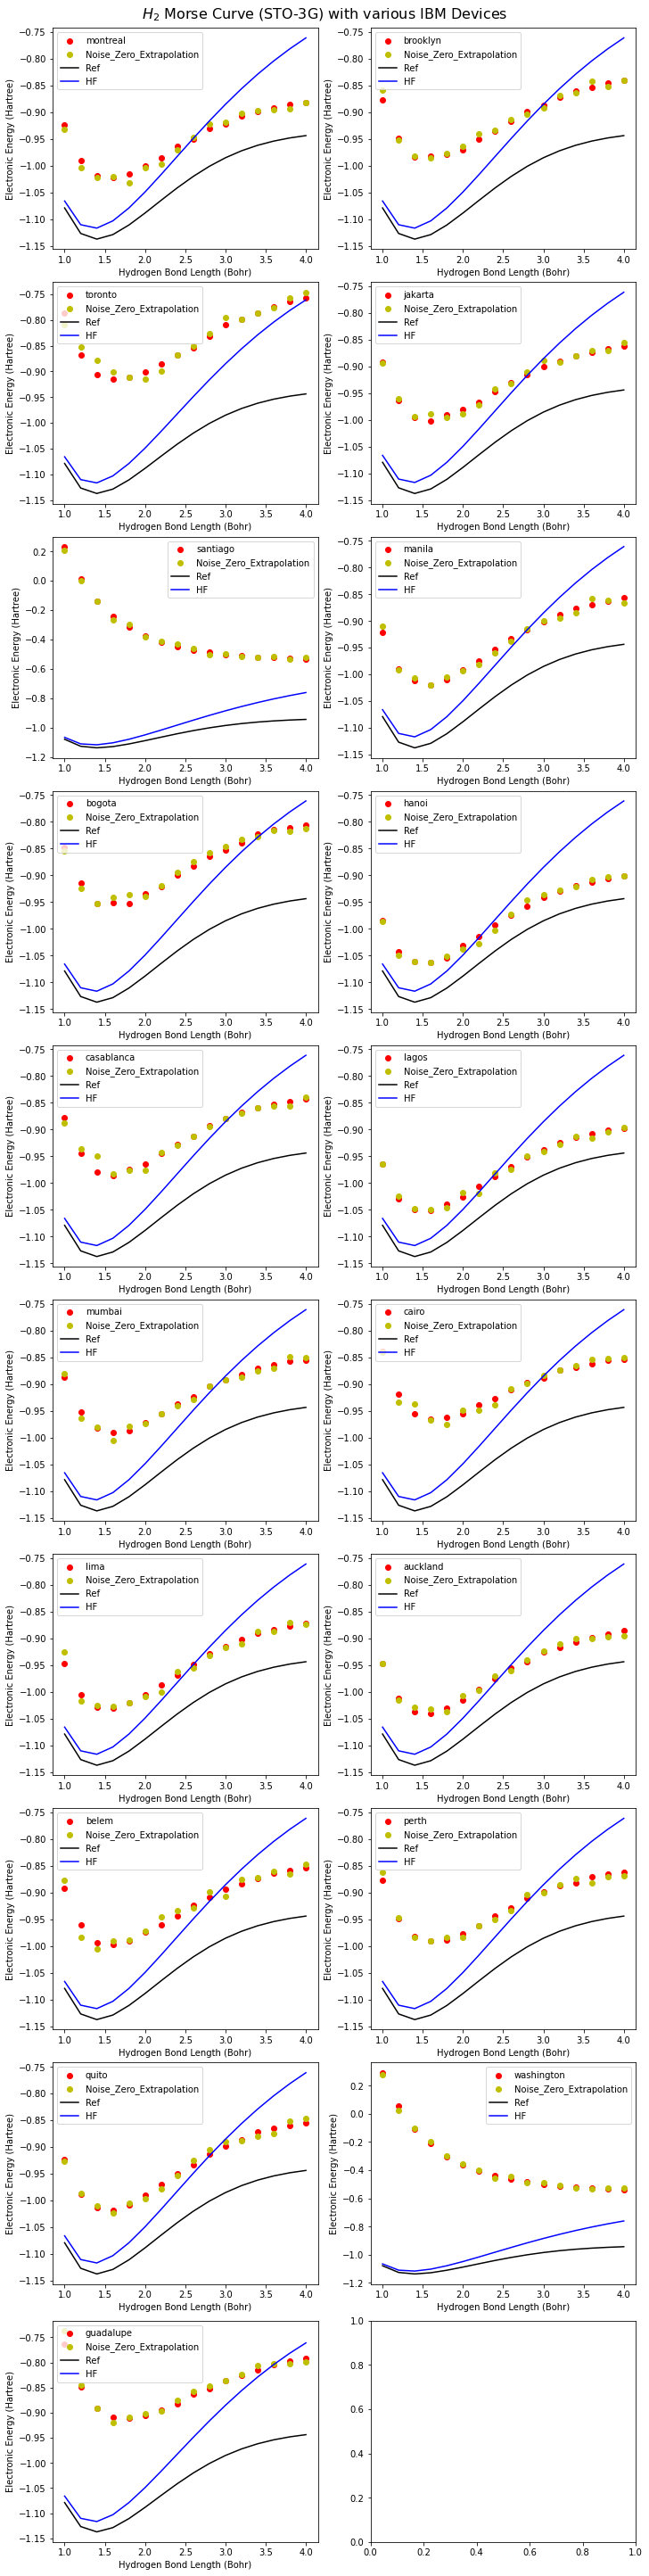

In [36]:
fig, ax = plt.subplots(10, 2, figsize=(10,40), constrained_layout=True)
fig.suptitle(r"$H_2$ Morse Curve (STO-3G) with various IBM Devices", fontsize=16)
for i in range(2):
    for j in range(10):
        if not((i==1) and (j==9)):
            ax[j][i].scatter(h2_opt_data['bond_length'], noisy_backend_noisy_morse[i*10+j], label=backend_list[i*10+j].split("_")[1], color='r')
            ax[j][i].scatter(h2_opt_data['bond_length'], mitig_noisy_backend_noisy_morse[i*10+j], label='Noise_Zero_Extrapolation', color='y')
            ax[j][i].plot(h2_opt_data['bond_length'], h2_opt_data['fci_ref_energy'], label='Ref', color='k')
            ax[j][i].plot(h2_opt_data['bond_length'], h2_opt_data['hf_ref_energy'], label='HF', color='b')
            ax[j][i].set_xlabel('Hydrogen Bond Length (Bohr)')
            ax[j][i].set_ylabel('Electronic Energy (Hartree)')
            ax[j][i].legend()

fig.savefig('h2_morse_noisy_and_mitig.png',format='png')


### IBM Noise Models of Quantum Devices

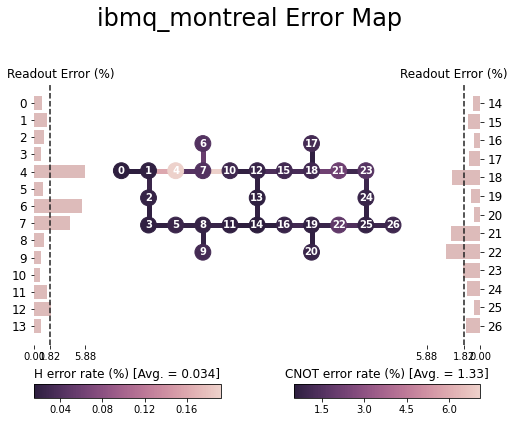

In [17]:
backend = provider.get_backend(backend_list[0])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

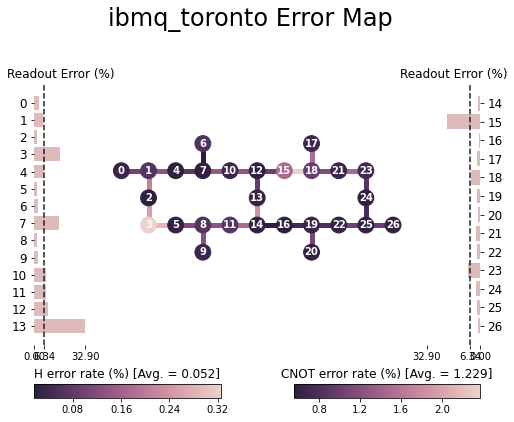

In [18]:
backend = provider.get_backend(backend_list[1])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

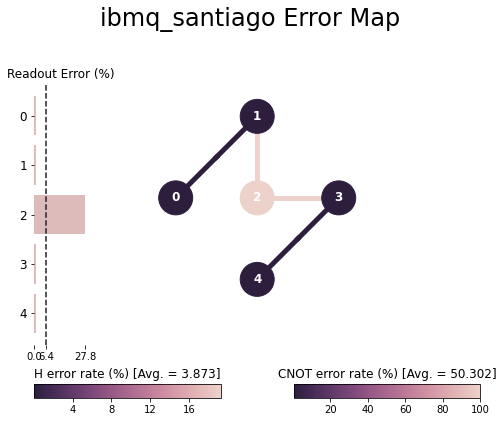

In [19]:
backend = provider.get_backend(backend_list[2])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

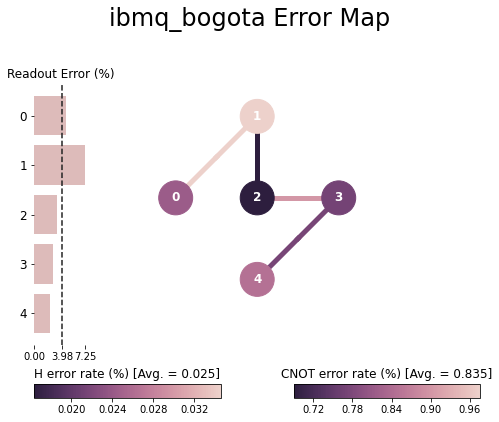

In [20]:
backend = provider.get_backend(backend_list[3])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

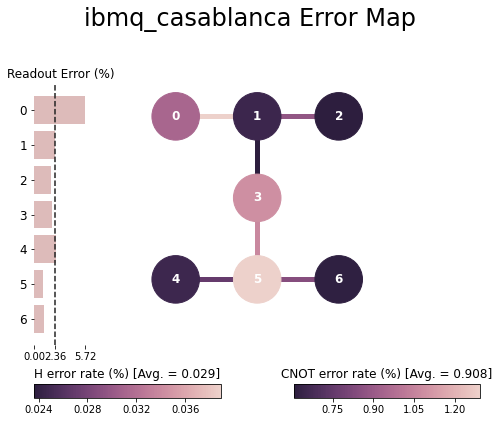

In [21]:
backend = provider.get_backend(backend_list[4])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

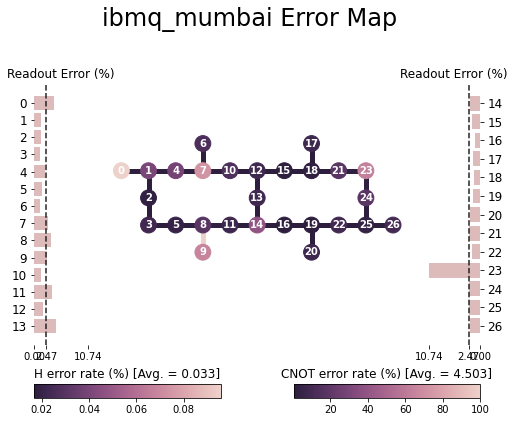

In [22]:
backend = provider.get_backend(backend_list[5])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

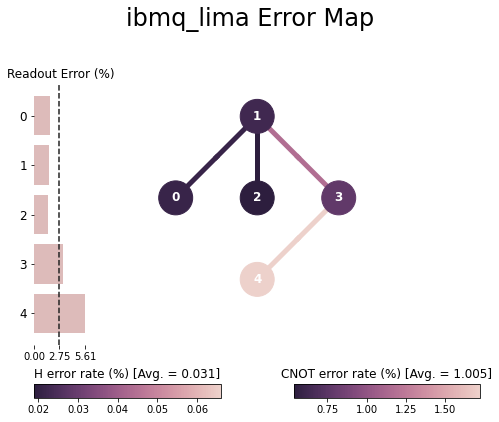

In [23]:
backend = provider.get_backend(backend_list[6])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

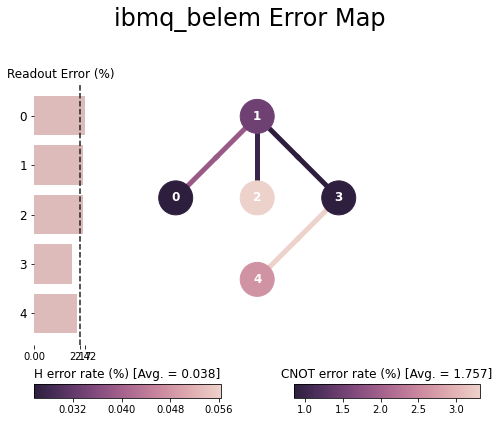

In [24]:
backend = provider.get_backend(backend_list[7])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

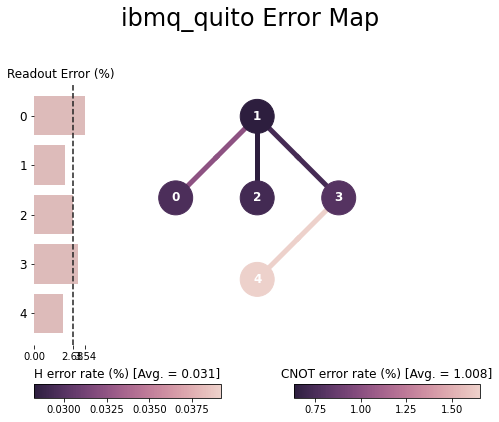

In [25]:
backend = provider.get_backend(backend_list[8])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

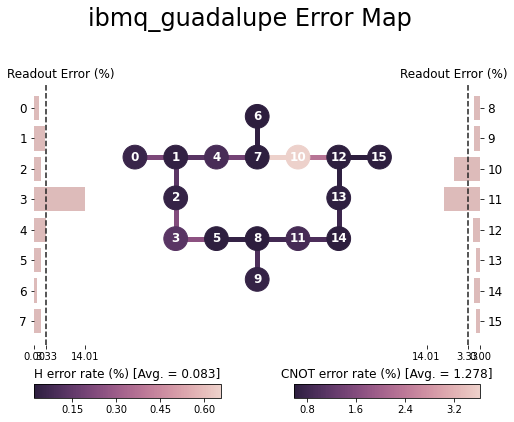

In [26]:
backend = provider.get_backend(backend_list[9])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

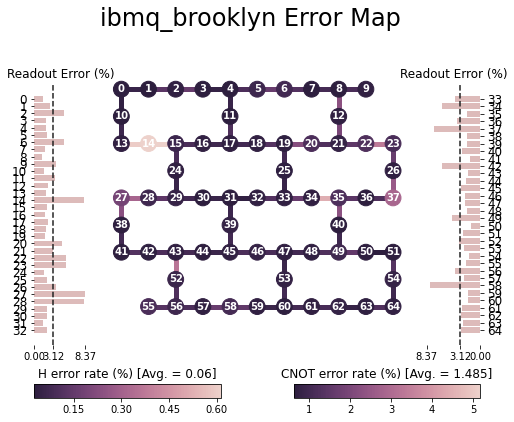

In [27]:
backend = provider.get_backend(backend_list[10])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

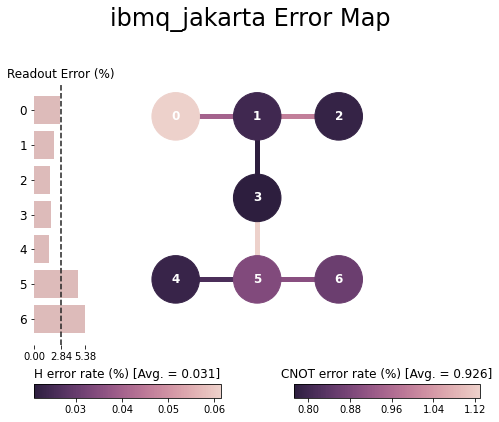

In [28]:
backend = provider.get_backend(backend_list[11])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

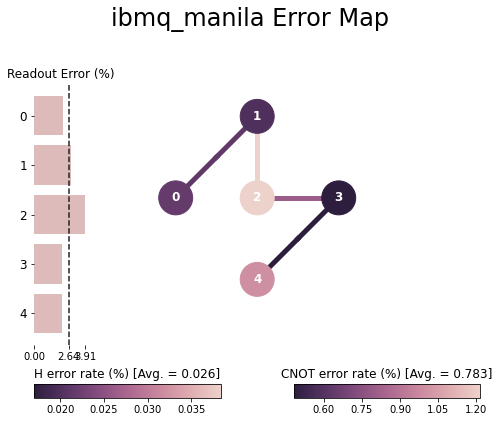

In [29]:
backend = provider.get_backend(backend_list[12])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

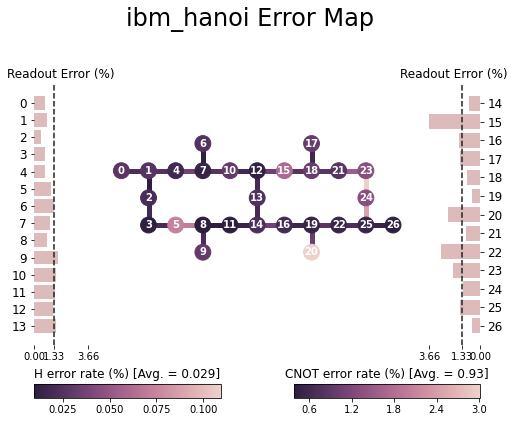

In [30]:
backend = provider.get_backend(backend_list[13])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

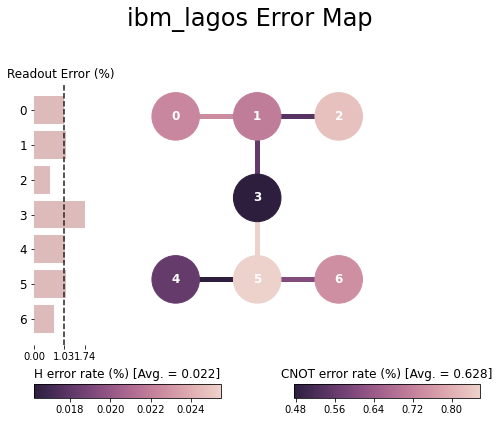

In [31]:
backend = provider.get_backend(backend_list[14])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

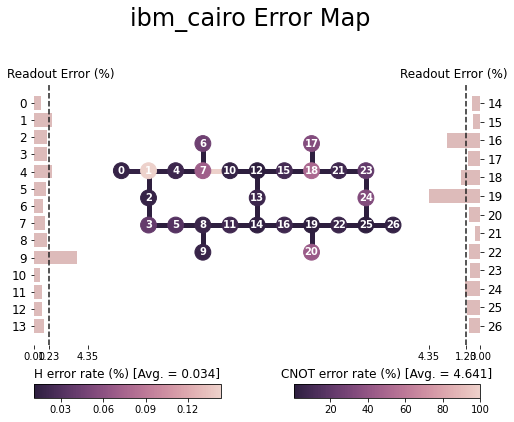

In [32]:
backend = provider.get_backend(backend_list[15])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

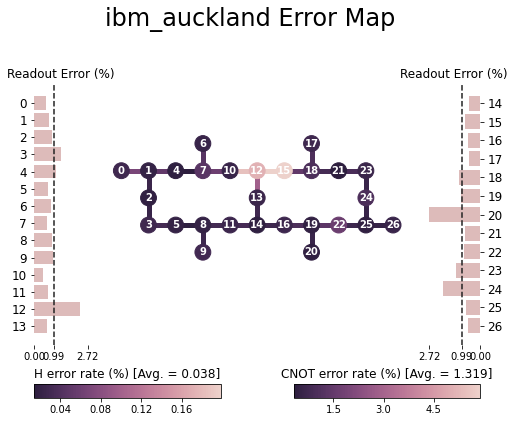

In [33]:
backend = provider.get_backend(backend_list[16])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

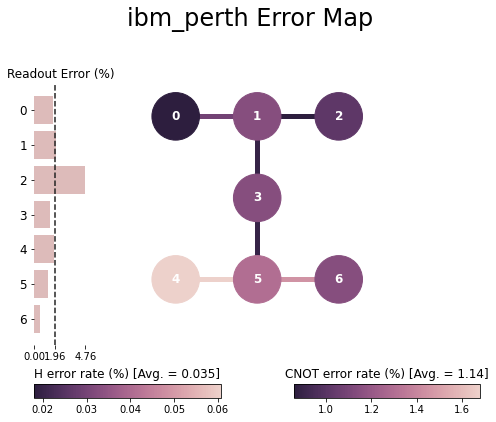

In [34]:
backend = provider.get_backend(backend_list[17])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

UnboundLocalError: local variable 'grid_data' referenced before assignment

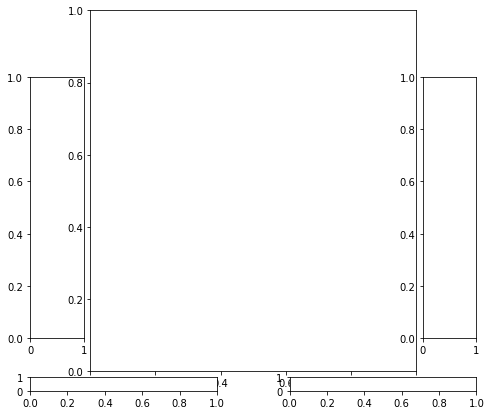

In [35]:
# This was supposed to be ibm_washington device
backend = provider.get_backend(backend_list[18])
qiskit.visualization.plot_error_map(backend, figsize=(8,7))

In [40]:
# for i in range(len(backend_list)):
#     backend = provider.get_backend(backend_list[0])
#     fig2 = qiskit.visualization.plot_error_map(backend, figsize=(7,6))
#     fig2.savefig('h2_pi_'+backend_list[i].split("_")[1]+'.png',format='png')